# Using DOM-QC to benchmark the quality of organellar maps data

For these analyses, you need to install the DOM-QC python package and its dependencies. Please refer to the [DOM-QC github page](https://github.com/valbrecht/SpatialProteomicsQC) for more information.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import pandas as pd
import re
import numpy as np
import domaps
import plotly.graph_objects as go
import plotly.express as px
import json
import plotly.io.orca as orca

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


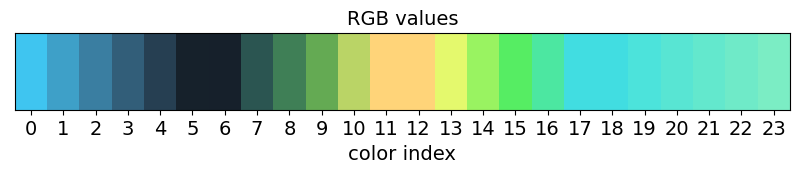

In [4]:
import matplotlib
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt

class AlphaPeptColorMap():
    def __init__(self):

        #colorlist = ["#3FC5F0", "#42DEE1", "#7BEDC5", "#FFD479", "#16212B"]
        colorlist = ["#3FC5F0","#16212B", "#FFD479", "#42DEE1", "#7BEDC5" ]
        self.colorlist = [matplotlib.colors.to_rgba(x) for x in colorlist]
        self.colorlist_hex = colorlist
        self.colormap_linear = matplotlib.colors.LinearSegmentedColormap.from_list("alphapept",self.colorlist)
        self.colormap_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("alphapept",self.colorlist, N=5)
        self.seaborn_mapname_linear = None
        self.seaborn_mapname_linear_cut = None
        self._define_linear_seaborn_palettes()
    
    def _define_linear_seaborn_palettes(self):
        cmap_registrator = CmapRegistrator()

        self.seaborn_mapname_linear = "alphapept_linear"
        cmap_registrator.register_colormap(self.seaborn_mapname_linear, self.colorlist)

        self.seaborn_mapname_linear_cut = "alphapept_linear_cut"
        cmap_registrator.register_colormap(self.seaborn_mapname_linear_cut, self.colorlist[:2])

    def extend_to_higher_number_of_colors(self, desired_number_of_colors):
        if desired_number_of_colors > len(self.colorlist):
            cmap_extender = ColorMapExtender(self.colorlist, desired_number_of_colors)
            self.colorlist = cmap_extender.rgb_list_interpolated
            #drop duplicates from numpy array
            #self.colorlist = np.unique(self.colorlist, axis=0)
            
            self.colorlist_hex= cmap_extender.hex_list_interpolated
        


class CmapRegistrator():
    def __init__(self):
        self._existing_matplotlib_cmaps = None
        self._define_existing_cmaps()
    
    def _define_existing_cmaps(self):
        self._existing_matplotlib_cmaps = [name for name in plt.colormaps() if not name.endswith('_r')]

    def register_colormap(self, name, colorlist):
        linmap = matplotlib.colors.LinearSegmentedColormap.from_list(name, colorlist)
        matplotlib.cm.register_cmap(name, linmap)
    

class ColorMapExtender():
    def __init__(self, rgb_list, desired_number_of_colors):
        self._rgb_list = rgb_list
        self._desired_number_of_colors = desired_number_of_colors

        self.hex_list_interpolated = None
        self.rgb_list_interpolated = None

        self._convert_colormap_discrete_to_interpolated()
    

    def _convert_colormap_discrete_to_interpolated(self):
        rgb_list = self._remove_alpha_value_from_rgb_list(self._rgb_list)
        hsv_list = self._convert_rgb_list_to_hsv(rgb_list)
        self.hsv_list_interpolated = self._apply_linear_interpolation(hsv_list)
        self.rgb_list_interpolated = [matplotlib.colors.hsv_to_rgb(hsv) for hsv in self.hsv_list_interpolated]
        self.hex_list_interpolated = [matplotlib.colors.to_hex(rgb) for rgb in self.rgb_list_interpolated]

    def _remove_alpha_value_from_rgb_list(self, rgb_list):
        return [rgb[:3] for rgb in rgb_list]

    @staticmethod
    def _convert_rgb_list_to_hsv(rgb_list):
        hsv_list = []
        for rgb in rgb_list:
            hsv_list.append(matplotlib.colors.rgb_to_hsv(rgb))
        return hsv_list


    def _apply_linear_interpolation(self, hsv_list):
        num_values = len(hsv_list)
        factor_of_extension = int(np.ceil(self._desired_number_of_colors / num_values))
        new_values = []
        for i in range(num_values-1):
            new_values.extend(self._interpolate_between_two_colors(hsv_list[i], hsv_list[i+1], factor_of_extension))
        return new_values

    @staticmethod
    def convert_rgb_to_hsv(rgb):
        hsv = matplotlib.colors.rgb_to_hsv(rgb)
        return hsv

    @staticmethod
    def _interpolate_between_two_colors(hsv1, hsv2, factor_of_extension):
        interpolated_colors = []
        for i in range(factor_of_extension +1):
            interpolated_colors.append((hsv1[0] + i / factor_of_extension * (hsv2[0] - hsv1[0]),
                            hsv1[1] + i / factor_of_extension * (hsv2[1] - hsv1[1]),
                            hsv1[2] + i / factor_of_extension * (hsv2[2] - hsv1[2])))
        return interpolated_colors


acm = AlphaPeptColorMap()
acm.extend_to_higher_number_of_colors(24)


print("")

acm.colorlist

#visualize the rgb values
fig, ax = plt.subplots(1,1, figsize=(10,1))
ax.imshow([acm.colorlist], aspect="auto")
ax.set_yticks([])
ax.set_xticks(np.arange(0, len(acm.colorlist), 1))
ax.set_xticklabels(np.arange(0, len(acm.colorlist), 1), fontsize=14)
ax.set_xlabel("color index", fontsize=14)
ax.set_title("RGB values", fontsize=14)
plt.show()

# Load data

In [5]:
protgroups_mq = "../../test_data/system_tests/organellar_maps/proteinGroups.txt"
protgroups_directlfq = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.protein_intensities.tsv.protgroups_format.txt"

In [6]:
df_pg_directlfq = pd.read_csv(protgroups_directlfq, sep="\t")
display(df_pg_directlfq)
map_cols = [x for x in df_pg_directlfq.columns if "Map" in x]
print(map_cols)
#add the string "Intensity " to the column names of df_pg_directlfq
map_cols_renamed = ["LFQ intensity " + x for x in map_cols]
col_rename = dict(zip(map_cols, map_cols_renamed))
df_pg_directlfq = df_pg_directlfq.rename(columns=col_rename)
display(df_pg_directlfq)

df_pg_directlfq.to_csv(protgroups_directlfq+".renamed.tsv", sep="\t", index=False)

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/2385478716.py:1: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pg_directlfq = pd.read_csv(protgroups_directlfq, sep="\t")


,LFQ intensity Map1_12K,LFQ intensity Map1_1K,LFQ intensity Map1_24K,LFQ intensity Map1_3K,LFQ intensity Map1_6K,LFQ intensity Map1_80K,LFQ intensity Map1_Cyt,LFQ intensity Map2_12K,LFQ intensity Map2_1K,LFQ intensity Map2_24K,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,0,67404866,0,306843195,258583889,0,0,0,79057270,0,...,NaN,0,11268;16295,True;True,12118;17534,114025;114026;114027;114028;114029;114030;1140...,103999;104000;104001;104002;104003;104004;1040...,103999;152163,NaN,NaN
1,0,0,0,246807408,188362162,0,0,0,57138863,0,...,NaN,2,56662,True,61531,586812;586813;586814;586815;586816;586817;586818,535881;535882;535883;535884;535885;535886;535887,535886,NaN,NaN
2,1485465532,1557447484,2220273298,0,1379776527,2645110695,477558494,1754431648,1482652938,2197578063,...,NaN,3,15025;16215;19649;27765;28539;32746;32789;3966...,True;True;True;True;True;True;True;True;True;T...,16186;17452;21123;29904;30735;35225;35268;4264...,154075;154076;154077;154078;154079;154080;1664...,140271;140272;140273;140274;140275;151525;1515...,140271;151525;181991;255805;262898;304290;3047...,2;3,39;455
3,0,0,0,0,0,0,0,0,0,0,...,NaN,4,12225;32711;48394;66252;66376,True;True;True;True;True,13141;35190;51940;72030;72165,125066;125067;125068;332816;332817;500824;5008...,113910;303770;303771;458020;617902;619151;619152,113910;303770;458020;617902;619152,NaN,NaN
4,540136468,1034089041,301691472,0,0,0,3126671840,482428406,1980069783,423210547,...,NaN,5,1170;3836;4957;8563;10264;16293;18501;23960;24...,True;True;True;True;True;True;True;True;True;T...,1257;4125;5328;9252;11049;17532;19900;25791;26...,12354;12355;12356;40193;40194;40195;52116;5211...,11465;11466;11467;36912;36913;36914;47718;4771...,11465;36914;47718;80796;94362;152160;171881;21...,4;5;6;7;8;9;10;11,56;162;492;872;909;985;992;998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,0,0,0,0,0,0,0,0,0,0,...,NaN,7403,37463,True,40214,384656,351471,351471,7557,185
7429,0,0,0,0,0,0,0,0,0,0,...,NaN,7410,44471,True,47757,460345,420675,420675,7562,173
7430,0,0,0,0,0,0,0,0,0,0,...,NaN,7412,45094,True,48421,466873;466874,426631;426632,426632,7563,188
7431,0,0,0,0,0,0,0,0,0,0,...,NaN,7417,65122,True,70848,668551,610330,610330,7567,76


['LFQ intensity Map1_12K', 'LFQ intensity Map1_1K', 'LFQ intensity Map1_24K', 'LFQ intensity Map1_3K', 'LFQ intensity Map1_6K', 'LFQ intensity Map1_80K', 'LFQ intensity Map1_Cyt', 'LFQ intensity Map2_12K', 'LFQ intensity Map2_1K', 'LFQ intensity Map2_24K', 'LFQ intensity Map2_3K', 'LFQ intensity Map2_6K', 'LFQ intensity Map2_80K', 'LFQ intensity Map2_Cyt', 'LFQ intensity Map3_12K', 'LFQ intensity Map3_1K', 'LFQ intensity Map3_24K', 'LFQ intensity Map3_3K', 'LFQ intensity Map3_6K', 'LFQ intensity Map3_80K', 'LFQ intensity Map3_Cyt', 'Peptides Map1_12K', 'Peptides Map1_1K', 'Peptides Map1_24K', 'Peptides Map1_3K', 'Peptides Map1_6K', 'Peptides Map1_80K', 'Peptides Map1_Cyt', 'Peptides Map2_12K', 'Peptides Map2_1K', 'Peptides Map2_24K', 'Peptides Map2_3K', 'Peptides Map2_6K', 'Peptides Map2_80K', 'Peptides Map2_Cyt', 'Peptides Map3_12K', 'Peptides Map3_1K', 'Peptides Map3_24K', 'Peptides Map3_3K', 'Peptides Map3_6K', 'Peptides Map3_80K', 'Peptides Map3_Cyt', 'Razor + unique peptides Map1_

,LFQ intensity LFQ intensity Map1_12K,LFQ intensity LFQ intensity Map1_1K,LFQ intensity LFQ intensity Map1_24K,LFQ intensity LFQ intensity Map1_3K,LFQ intensity LFQ intensity Map1_6K,LFQ intensity LFQ intensity Map1_80K,LFQ intensity LFQ intensity Map1_Cyt,LFQ intensity LFQ intensity Map2_12K,LFQ intensity LFQ intensity Map2_1K,LFQ intensity LFQ intensity Map2_24K,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,0,67404866,0,306843195,258583889,0,0,0,79057270,0,...,NaN,0,11268;16295,True;True,12118;17534,114025;114026;114027;114028;114029;114030;1140...,103999;104000;104001;104002;104003;104004;1040...,103999;152163,NaN,NaN
1,0,0,0,246807408,188362162,0,0,0,57138863,0,...,NaN,2,56662,True,61531,586812;586813;586814;586815;586816;586817;586818,535881;535882;535883;535884;535885;535886;535887,535886,NaN,NaN
2,1485465532,1557447484,2220273298,0,1379776527,2645110695,477558494,1754431648,1482652938,2197578063,...,NaN,3,15025;16215;19649;27765;28539;32746;32789;3966...,True;True;True;True;True;True;True;True;True;T...,16186;17452;21123;29904;30735;35225;35268;4264...,154075;154076;154077;154078;154079;154080;1664...,140271;140272;140273;140274;140275;151525;1515...,140271;151525;181991;255805;262898;304290;3047...,2;3,39;455
3,0,0,0,0,0,0,0,0,0,0,...,NaN,4,12225;32711;48394;66252;66376,True;True;True;True;True,13141;35190;51940;72030;72165,125066;125067;125068;332816;332817;500824;5008...,113910;303770;303771;458020;617902;619151;619152,113910;303770;458020;617902;619152,NaN,NaN
4,540136468,1034089041,301691472,0,0,0,3126671840,482428406,1980069783,423210547,...,NaN,5,1170;3836;4957;8563;10264;16293;18501;23960;24...,True;True;True;True;True;True;True;True;True;T...,1257;4125;5328;9252;11049;17532;19900;25791;26...,12354;12355;12356;40193;40194;40195;52116;5211...,11465;11466;11467;36912;36913;36914;47718;4771...,11465;36914;47718;80796;94362;152160;171881;21...,4;5;6;7;8;9;10;11,56;162;492;872;909;985;992;998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,0,0,0,0,0,0,0,0,0,0,...,NaN,7403,37463,True,40214,384656,351471,351471,7557,185
7429,0,0,0,0,0,0,0,0,0,0,...,NaN,7410,44471,True,47757,460345,420675,420675,7562,173
7430,0,0,0,0,0,0,0,0,0,0,...,NaN,7412,45094,True,48421,466873;466874,426631;426632,426632,7563,188
7431,0,0,0,0,0,0,0,0,0,0,...,NaN,7417,65122,True,70848,668551,610330,610330,7567,76


In [7]:
file = "../../test_data/system_tests/organellar_maps/AnalysedDatasets(13).json"
with open(file) as file_input:
    content = json.load(file_input)

## Check experiment names and set order

In [8]:
content.keys()

dict_keys(['MaxLFQ', 'directLFQ'])

In [9]:
experiment_order = ['directLFQ', 'MaxLFQ']

## Align datasets

In [10]:
comp = domaps.SpatialDataSetComparison(ref_exp="directLFQ")
comp.json_dict = {k: content[k] for k in experiment_order}
comp.read_jsonFile()
comp.calc_biological_precision()
comp.get_complex_coverage()
comp.perform_pca_comparison()
#comp.svm_processing()

/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(df_p)
/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(df_p)
/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(df_p)
/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2162: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(df_p)
/Users/constantin/workspace/

## Profile plots

In [11]:
acm = AlphaPeptColorMap()
colorlist_alphapept = acm.colorlist_hex

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1158847961.py:49: UserWarning: Trying to register the cmap 'alphapept_linear' which already exists.
  matplotlib.cm.register_cmap(name, linmap)
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1158847961.py:49: UserWarning: Trying to register the cmap 'alphapept_linear_cut' which already exists.
  matplotlib.cm.register_cmap(name, linmap)


6


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:6: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  lfq_df = pd.read_csv(lfq_file, sep="\t" )


6


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:6: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  lfq_df = pd.read_csv(lfq_file, sep="\t" )
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.replace("LFQ intensity Map3_", "") for x in lfq_df.columns], rotation=90)
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.replace("LFQ intensity Map3_", "") for x in lfq_df.columns], rotation=90)


14


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:6: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  lfq_df = pd.read_csv(lfq_file, sep="\t" )


14


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:6: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  lfq_df = pd.read_csv(lfq_file, sep="\t" )
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.replace("LFQ intensity Map3_", "") for x in lfq_df.columns], rotation=90)
/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_53921/1888659582.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.replace("LFQ intensity Map3_", "") for x in lfq_df.columns], rotation=90)


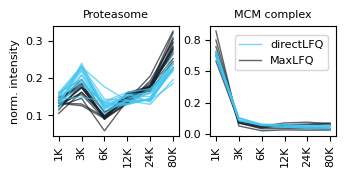

In [12]:
import matplotlib.ticker as tick

def obtain_cluster_protein_profiles(lfq_file, cluster_name, cluster2protein_dict, map):
    proteins_of_interest = cluster2protein_dict[cluster_name]
    print(len(proteins_of_interest))
    lfq_df = pd.read_csv(lfq_file, sep="\t" )
    lfq_df = lfq_df[[check_if_cluster_protein_in_protein_group(x ,proteins_of_interest) for x in lfq_df["Protein IDs"]]]
    lfq_df = lfq_df.set_index("Protein IDs")
    lfq_df = lfq_df.loc[:, lfq_df.columns.str.contains("LFQ intensity") & lfq_df.columns.str.contains(map) & ~(lfq_df.columns.str.contains("Cyt"))]
    lfq_df = normlize_each_row_to_01(lfq_df)
    lfq_df = rearrange_columns_by_name(lfq_df)
    return lfq_df

def check_if_cluster_protein_in_protein_group(protein_group, set_of_cluster_proteins):
    protein_group = protein_group.split(";")
    return len(set(protein_group).intersection(set_of_cluster_proteins))>0

def normlize_each_row_to_01(df):
    df = df.copy()
    for index, row in df.iterrows():
        df.loc[index] = row/row.sum()
    return df

def rearrange_columns_by_name(df):
    df = df.copy()
    sorted_cols = sorted(df.columns, key=lambda x: int(x.split("_")[-1].replace("K", "")))
    df = df.reindex(sorted_cols, axis=1)
    return df

def plot_trace_per_row(lfq_df, ax, color, label):
    #set color to light grey
    for i in range(lfq_df.shape[0]):
        label = label if i==0 else None
        ax.plot(lfq_df.iloc[i, :], color=color, alpha=0.7, label=label, lw=1)
    #rotate xticks by 90 degrees
    ax.set_xticklabels([x.replace("LFQ intensity Map3_", "") for x in lfq_df.columns], rotation=90)
    #set yticks to have 1 decimal place
    ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))


cluster_of_interest = "MCM complex"
cluster_of_interest = "60S ribosomal subunit, cytoplasmic"
#cluster_of_interest = "Nuclear pore complex"

def plot_cluster_profile(protgroups_mq, protgroups_directlfq, cluster_of_interest, comp, map, ax):
    lfq_df = obtain_cluster_protein_profiles(protgroups_mq, cluster_of_interest,comp.markerproteins, map)
    directlfq_df = obtain_cluster_protein_profiles(protgroups_directlfq, cluster_of_interest,comp.markerproteins, map)

    directlfq_color = acm.colorlist[0]
    mq_color = acm.colorlist[1]
    plot_trace_per_row(lfq_df, ax, mq_color, "MaxLFQ")
    plot_trace_per_row(directlfq_df, ax,directlfq_color, "directLFQ")
    ax.set_label("")
    ax.set_ylabel("norm. intensity")
    ax.set_title(cluster_of_interest)

fig, axes = plt.subplots(1,2, figsize=(3.5,2.5*0.69))


plot_cluster_profile(protgroups_mq, protgroups_directlfq, "MCM complex", comp, "Map3", axes[1])
plot_cluster_profile(protgroups_mq, protgroups_directlfq, "Proteasome", comp, "Map3", axes[0])
#set one legend for both subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='lower center', ncol=1, bbox_to_anchor=(0.81, 0.55))

#remove ylabel of second subplot
axes[1].set_ylabel("")
fig.tight_layout()

#reduce space between subplots
fig.subplots_adjust(bottom=0.2, wspace=0.25)

fig.savefig("cluster_profiles.pdf", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig("cluster_profiles.svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig("cluster_profiles.png", bbox_inches="tight", dpi=300, transparent=True)



## Intra complex scatter

In [13]:
clusters = ["28S ribosomal subunit, mitochondrial",
            "39S ribosomal subunit, mitochondrial",
            "40S ribosomal subunit, cytoplasmic",
            "60S ribosomal subunit, cytoplasmic",
            "Arp2/3 protein complex",
            "CCT complex",
            "Coatomer complex",
            "COP9 signalosome complex",
            "Dynactin complex",
            "EMC",
            "F1F0 ATP synthase",
            "MCM complex",
            "Multisynthetase complex",
            "Nup107-160 subcomplex",
            "Nuclear pore complex",
            "Prefoldin complex",
            "Proteasome",
            "Respiratory chain complex I core",
            "Sec6/8 exocyst complex",
            "V-type proton ATPase V1"]





bp = comp.plot_biological_precision(experiment_order,
                               clusters_for_ranking=clusters,
                              reference="MaxLFQ")

/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2392: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_c = df_m.groupby(["Cluster", "Experiment"]).median().reset_index()
/Users/constantin/workspace/SpatialProteomicsQC/domaps/domaps.py:2393: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_m = df_m.groupby(["Cluster", "Experiment", "Map"]).median().reset_index()


In [14]:
def swap_neighboring_colors(colorlist):
    for i in range(0, len(colorlist), 2):
        colorlist[i], colorlist[i+1] = colorlist[i+1], colorlist[i]
    return colorlist

V-type proton ATPase V1
Dynactin complex
Nuclear pore complex
EMC
Nup107-160 subcomplex
COP9 signalosome complex
Proteasome
Sec6/8 exocyst complex
Prefoldin complex
MCM complex
60S ribosomal subunit, cytoplasmic
40S ribosomal subunit, cytoplasmic
39S ribosomal subunit, mitochondrial
Multisynthetase complex
F1F0 ATP synthase
Arp2/3 protein complex
28S ribosomal subunit, mitochondrial
Respiratory chain complex I core
CCT complex
Coatomer complex


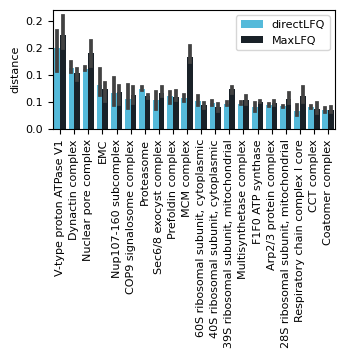

In [15]:
import seaborn as sns
import matplotlib.ticker as tick
df_barplot = bp[3]


#create stacked barplot with seaborn
fig, ax = plt.subplots(figsize=(7*0.52,2.5*0.62))
sns.barplot(data=df_barplot, x = "Cluster", y = "distance", hue = "Experiment",ax=ax, palette=colorlist_alphapept)
#set xlabels to be rotated
plt.xticks(rotation=90)
ax.set_xlabel("")
#set yticks to have 1 decimal place
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
#remove legend title
ax.get_legend().set_title(None)

fig.savefig("variation_in_complexes_barplot.svg", dpi=300, bbox_inches="tight")
fig.savefig("variation_in_complexes_barplot.pdf", dpi=300, bbox_inches="tight")
fig.savefig("variation_in_complexes_barplot.png", dpi=300, bbox_inches="tight")


#print xlabels
for i, label in enumerate(ax.get_xticklabels()):
    print(label.get_text())

In [36]:
import scipy.stats
def perform_ttest_on_distances(df_distances):
	distances_directlfq = df_distances[df_distances["Experiment"]=="directLFQ"]["distance"].values
	distances_maxlfq = df_distances[df_distances["Experiment"]=="MaxLFQ"]["distance"].values
	ttest = scipy.stats.ttest_ind(distances_directlfq, distances_maxlfq)
	
	print("ttest p-value: {}".format(ttest.pvalue))
	print("ttest statistic: {}".format(ttest.statistic))


/Users/constantin/opt/anaconda3/envs/domqc/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



,Cluster,Experiment,Map,distance
0,"28S ribosomal subunit, mitochondrial",MaxLFQ,Map1,0.013222
1,"28S ribosomal subunit, mitochondrial",MaxLFQ,Map2,0.008672
2,"28S ribosomal subunit, mitochondrial",MaxLFQ,Map3,0.026230
3,"28S ribosomal subunit, mitochondrial",directLFQ,Map1,0.003488
4,"28S ribosomal subunit, mitochondrial",directLFQ,Map2,0.000000
...,...,...,...,...
115,V-type proton ATPase V1,MaxLFQ,Map2,0.054567
116,V-type proton ATPase V1,MaxLFQ,Map3,0.042598
117,V-type proton ATPase V1,directLFQ,Map1,0.093078
118,V-type proton ATPase V1,directLFQ,Map2,0.037546


/Users/constantin/opt/anaconda3/envs/domqc/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



ttest p-value: 0.014039678162602664
ttest statistic: -2.4933694274704195


/Users/constantin/opt/anaconda3/envs/domqc/lib/python3.8/site-packages/seaborn/categorical.py:3543: UserWarning:

10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



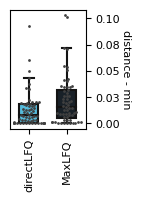

In [37]:
import seaborn as sns
import matplotlib.ticker as tick

fig, ax = plt.subplots(figsize=(2.5*0.39,2.5*0.62))
df_barplot_reformed = df_barplot.set_index(["Experiment", "Cluster", "Map"]).unstack(["Experiment", "Map"])\
                                      .apply(lambda x: x-x.min(), axis=1).stack(["Experiment", "Map"]).reset_index()

sns.boxplot(data=df_barplot_reformed, x = "Experiment", y = "distance", palette=colorlist_alphapept, showfliers=False, order = ['directLFQ', 'MaxLFQ'], ax = ax, width=0.5)
sns.swarmplot(data=df_barplot_reformed, x = "Experiment", y = "distance", color=".25", ax = ax, order = ['directLFQ', 'MaxLFQ'], size=2)
ax.set_ylabel("distance - min", rotation=270, labelpad=8)
ax.set_xlabel("")
#set yticks to two decimal places
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
#rotate xtick labels
plt.xticks(rotation=90)
#move yticks to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

display(df_barplot_reformed)
perform_ttest_on_distances(df_barplot_reformed)


fig.savefig("variation_in_complexes_boxplot.svg", dpi=300, bbox_inches="tight", transparent=True)
fig.savefig("variation_in_complexes_boxplot.pdf", dpi=300, bbox_inches="tight", transparent=True)
fig.savefig("variation_in_complexes_boxplot.png", dpi=300, bbox_inches="tight", transparent=True)

## Venn diagram

In [31]:
print(set(comp.markerproteins.keys()))
def invert_dict_mapping_to_list(dict_mapping_to_list):
    inverted_dict = {}
    for key, value in dict_mapping_to_list.items():
        for item in value:
            inverted_dict[item] = key
    return inverted_dict


protein2cluster_dict = invert_dict_mapping_to_list(comp.markerproteins)
#add element to index
plot_df = comp.df_01_filtered_combined.copy()
plot_df["Cluster"] = plot_df.index.get_level_values("Protein IDs").map(protein2cluster_dict)
#rename Cluster column
plot_df["Cluster"] = plot_df["Cluster"].fillna("undefined")
#add cluster column to index
plot_df = plot_df.set_index("Cluster", append=True)



{'39S ribosomal subunit, mitochondrial', 'Nuclear pore complex', 'RNase MRP complex', 'EMC', 'Coatomer complex', 'F1F0 ATP synthase', 'Multisynthetase complex', 'AP2 adaptor complex', 'Respiratory chain complex I core', 'Dynactin complex', 'V-type proton ATPase V1', 'Respiratory chain complex I complete', '60S ribosomal subunit, cytoplasmic', 'CCT complex', 'Replication factor C', 'V-type proton ATPase V0', 'Sec6/8 exocyst complex', 'Prefoldin complex', 'MCM complex', 'Proteasome', '40S ribosomal subunit, cytoplasmic', 'AP4 adaptor complex', 'RNA exosome complex', 'GPI transamidase complex', '28S ribosomal subunit, mitochondrial', 'Arp2/3 protein complex', 'AP1 adaptor complex', 'AP3 adaptor complex', 'Wave Regulatory complex', 'COP9 signalosome complex', 'THO complex', 'Nup107-160 subcomplex', 'Anaphase-promoting complex'}


In [32]:
plotdata=pd.DataFrame()
display(plot_df.reset_index()["Cluster"].unique())
for el in set(plot_df.index.get_level_values("Cluster")):
    el_df = plot_df.xs(el, level="Cluster", axis=0, drop_level=False)
    plotdata = plotdata.append(el_df.stack("Fraction").groupby(["Cluster", "Map", "Experiment", "Fraction"])\
        .apply(lambda x: pd.Series({"Profile [% total signal]": np.nanmean(x), "std":np.nanstd(x),
                                    "sem":np.nanstd(x)/np.sqrt(sum(np.isfinite(x)))}))\
        .reset_index().rename(columns={"level_4": "measure", 0: "value"})\
        .set_index(["Cluster", "Map", "Experiment", "Fraction", "measure"]).unstack("measure")\
        .droplevel(0, axis=1).reset_index())
plotdata.sort_values("Fraction", key=domaps.natsort_list_keys, inplace=True)

display(plotdata)

array(['undefined', 'Wave Regulatory complex', 'Dynactin complex',
       'Arp2/3 protein complex', 'Multisynthetase complex', 'THO complex',
       'Anaphase-promoting complex', 'AP1 adaptor complex',
       'AP2 adaptor complex', 'AP3 adaptor complex', 'Coatomer complex',
       'F1F0 ATP synthase', 'V-type proton ATPase V0',
       'V-type proton ATPase V1', 'CCT complex',
       'COP9 signalosome complex', '28S ribosomal subunit, mitochondrial',
       'EMC', 'Sec6/8 exocyst complex', 'RNA exosome complex',
       '40S ribosomal subunit, cytoplasmic', 'GPI transamidase complex',
       'MCM complex', '39S ribosomal subunit, mitochondrial',
       'Respiratory chain complex I complete',
       'Respiratory chain complex I core', 'Nuclear pore complex',
       'Prefoldin complex', 'RNase MRP complex', 'Proteasome',
       'Replication factor C', '60S ribosomal subunit, cytoplasmic'],
      dtype=object)

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/608102845.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/608102845.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/608102845.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/608102845.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/608102845.py:5: FutureWarning:

The frame.append method is deprecated a

measure,Cluster,Map,Experiment,Fraction,Profile [% total signal],sem,std
25,CCT complex,Map3,MaxLFQ,1K,0.174367,0.003143,0.008891
1,Dynactin complex,Map1,MaxLFQ,1K,0.039115,0.013203,0.037344
31,Respiratory chain complex I core,Map3,directLFQ,1K,0.127560,0.005275,0.013957
7,COP9 signalosome complex,Map1,directLFQ,1K,0.284161,0.012077,0.029582
25,GPI transamidase complex,Map3,MaxLFQ,1K,0.122873,0.003527,0.007886
...,...,...,...,...,...,...,...
29,Prefoldin complex,Map3,MaxLFQ,80K,0.239460,0.011055,0.024720
23,Prefoldin complex,Map2,directLFQ,80K,0.219503,0.008991,0.020104
17,Prefoldin complex,Map2,MaxLFQ,80K,0.249585,0.006963,0.015570
5,Prefoldin complex,Map1,MaxLFQ,80K,0.260400,0.012237,0.027363


In [33]:
acm_profiles = AlphaPeptColorMap()
colorlist_hex = acm_profiles.colorlist_hex
color_discrete_map = {'MaxLFQ': colorlist_hex[1], 'directLFQ': colorlist_hex[0]}

plotdata_reduced_to_most_differing_clusters = plotdata.loc[plotdata["Cluster"].isin(["60S ribosomal subunit, cytoplasmic","MCM complex"])]
display(plotdata_reduced_to_most_differing_clusters)
# plotdata_reduced_to_most_differing_clusters.sort_values(["Experiment"], inplace=True, ascending=False)
# plotdata_reduced_to_most_differing_clusters.sort_values(["Fraction"], inplace=True, ascending=True)

Cluster_plot = px.line(plotdata_reduced_to_most_differing_clusters,
                           x="Fraction", y="Profile [% total signal]", error_y="sem",
                           color="Experiment", line_group="Map",line_dash="Cluster",
                           template="simple_white", color_discrete_map=color_discrete_map).update_layout(
        width=600, height=350, showlegend=True,
    )

Cluster_plot.show()
Cluster_plot.write_image("Cluster_traces.svg")

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/1158847961.py:49: UserWarning:

Trying to register the cmap 'alphapept_linear' which already exists.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/1158847961.py:49: UserWarning:

Trying to register the cmap 'alphapept_linear_cut' which already exists.



measure,Cluster,Map,Experiment,Fraction,Profile [% total signal],sem,std
31,MCM complex,Map3,directLFQ,1K,0.638446,0.007659,0.018760
31,"60S ribosomal subunit, cytoplasmic",Map3,directLFQ,1K,0.056147,0.001414,0.009161
25,"60S ribosomal subunit, cytoplasmic",Map3,MaxLFQ,1K,0.045180,0.001125,0.007292
25,MCM complex,Map3,MaxLFQ,1K,0.684677,0.032602,0.079859
1,MCM complex,Map1,MaxLFQ,1K,0.719205,0.033806,0.082807
...,...,...,...,...,...,...,...
29,MCM complex,Map3,MaxLFQ,80K,0.059141,0.009028,0.022114
23,MCM complex,Map2,directLFQ,80K,0.053136,0.004260,0.010434
17,MCM complex,Map2,MaxLFQ,80K,0.059279,0.009143,0.022396
11,MCM complex,Map1,directLFQ,80K,0.049158,0.005070,0.012420


In [34]:
plotdata_reduced_to_clusters_of_interest = plotdata.loc[plotdata["Cluster"].isin(["Nuclear pore complex", "Endosome","Plasma membrane"])]
#plotdata_reduced_to_clusters_of_interest.sort_values(["Experiment"], inplace=True, ascending=False)
#plotdata_reduced_to_clusters_of_interest.sort_values(["Fraction"], inplace=True, ascending=True)

compartment_plot = px.line(plotdata_reduced_to_clusters_of_interest,
                           x="Fraction", y="Profile [% total signal]", error_y="sem",
                           color="Experiment", line_group="Map",line_dash="Cluster",
                           template="simple_white", color_discrete_map=color_discrete_map).update_layout(
        width=600, height=350, showlegend=True,
    )

compartment_plot.show()
compartment_plot.write_image("compartment_traces.svg")


In [35]:
def visualize_colorlist_hex(colorlist_hex):
    fig, ax = plt.subplots(1,1, figsize=(10,1))
    ax.bar(np.arange(len(colorlist_hex)), np.ones(len(colorlist_hex)), color=colorlist_hex)
    ax.set_xticks(np.arange(len(colorlist_hex)))
    ax.set_xticklabels(np.arange(len(colorlist_hex)))
    ax.set_yticks([])
    ax.set_ylabel("Color")
    ax.set_xlabel("Color index")
    plt.show()

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/1158847961.py:49: UserWarning:

Trying to register the cmap 'alphapept_linear' which already exists.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_82165/1158847961.py:49: UserWarning:

Trying to register the cmap 'alphapept_linear_cut' which already exists.



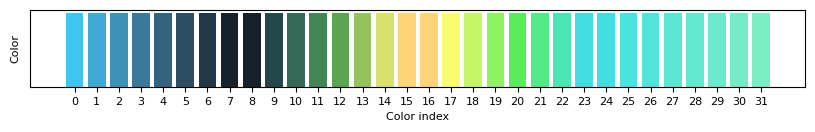

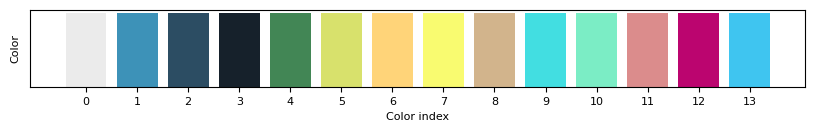

In [36]:
acm_pca = AlphaPeptColorMap()
acm_pca.extend_to_higher_number_of_colors(33)
colorlist_hex = acm_pca.colorlist_hex

visualize_colorlist_hex(colorlist_hex)

colorlist_hex_idxs_to_use = [0, 2, 5, 7, 11, 14, 16, 17, 20, 23, 31]
colors_to_add = ['#DB8C8C', '#BB056F', "#EBEBEB"]
colorlist_hex_final = [colorlist_hex[i] for i in colorlist_hex_idxs_to_use] + colors_to_add

#swap start and end
colorlist_hex_final[0], colorlist_hex_final[-1] = colorlist_hex_final[-1], colorlist_hex_final[0]
colorlist_hex_final[8] = "#D2B48C"
visualize_colorlist_hex(colorlist_hex_final)


In [258]:



global_pca_figure, df_global_pca = comp.plot_global_pca_comparison(multi_choice=[ 'directLFQ', 'MaxLFQ'])
ordered_legends = ['undefined', 'Nuclear pore complex', 'Mitochondrion', 'ER', 'ER_high_curvature',  'Lysosome', 'Large Protein Complex', 'Actin binding proteins','Plasma membrane' , 'Peroxisome', 'Ergic/cisGolgi', 'Golgi', 'Endosome' ]
#reorder tuple to have the same order as in the legend

name2datasets = {}
for dataset in global_pca_figure.data:
    name2datasets[dataset.name] =  name2datasets.get(dataset.name, []) +[dataset]

reordered_datasets = []
for name in ordered_legends:
    if name in name2datasets:
        datasets = name2datasets[name]
        datasets = datasets[::-1]
        reordered_datasets.extend(datasets)

global_pca_figure.data = reordered_datasets


legends = list({x.legendgroup for x in global_pca_figure.data})
print(legends)

acm_pca.extend_to_higher_number_of_colors(len(legends))
colorlist_hex = acm_pca.colorlist_hex
colorlist_hex = swap_neighboring_colors(colorlist_hex)
colorlist_hex[legends.index('undefined')] = "#EBEBEB"

#colorlist_hex = [  '#16212b',          '#54e5d6' ,          '#67e9cb',      '#EBEBEB',      '#397258', '#ffd479',               '#ffd479',              '#7eb85a', '#b3f565','#3fc5f0',         '#7bedc5', '#53eb77','#3c8aae',        '#42dee1', ]
legend_dict=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.7,
    xanchor="right",
    x=1
    )

global_pca_figure.update_layout(autosize=False, 
                                     width=1000, 
                                     height=400,
                                     template="simple_white",
                                     legend=legend_dict,
                                     title = "",
                                     ).for_each_trace(lambda x: x.update(marker_color=colorlist_hex_final[ordered_legends.index(x.name)], marker_line_color="black"))

# global_pca_figure.show()
# global_pca_figure.write_image("pca_comparison.svg")
# global_pca_figure.write_image("pca_comparison.pdf")
# global_pca_figure.write_image("pca_comparison.pdf")


,index,Gene names,Protein IDs,merge type,Compartment,Experiment,PC1,PC2,PC3,Cluster,Compartment_lexicographic_sort
1,1,AAAS,Q9NRG9,primary id,undefined,MaxLFQ,-0.366360,0.482159,0.880855,Undefined,undefined
3,3,AAK1,Q2M2I8,primary id,undefined,MaxLFQ,1.731799,-0.370085,-0.847222,Undefined,undefined
5,5,AARS,P49588,primary id,undefined,MaxLFQ,0.787852,-0.006267,-0.148404,Undefined,undefined
7,7,AASDHPPT,Q9NRN7,primary id,undefined,MaxLFQ,0.441588,0.288659,-0.730327,Undefined,undefined
10,10,ABCB10,Q9NRK6,primary id,undefined,MaxLFQ,-2.776458,0.406721,-1.387634,Undefined,undefined
...,...,...,...,...,...,...,...,...,...,...,...
6788,6788,STXBP3,O00186,primary id,Plasma membrane,directLFQ,-0.895559,-0.143972,0.044800,Undefined,Plasma membrane
6962,6962,TGFBR3,Q03167,primary id,Plasma membrane,directLFQ,-1.510622,-0.423364,0.287311,Undefined,Plasma membrane
7649,7649,VANGL1,Q8TAA9,primary id,Plasma membrane,directLFQ,-1.524947,-0.283620,0.248670,Undefined,Plasma membrane
7829,7829,XPR1,Q9UBH6,primary id,Plasma membrane,directLFQ,-1.411514,-0.072263,0.092531,Undefined,Plasma membrane


['Actin binding proteins', 'ER_high_curvature', 'ER', 'Mitochondrion', 'Lysosome', 'Ergic/cisGolgi', 'Golgi', 'Endosome', 'Large Protein Complex', 'Plasma membrane', 'undefined', 'Nuclear pore complex', 'Peroxisome']


,Compartment,index,Gene names,Protein IDs,merge type,Experiment,PC1,PC2,PC3,Cluster,Compartment_lexicographic_sort
0,undefined,1,AAAS,Q9NRG9,primary id,MaxLFQ,-0.366360,0.482159,0.880855,Undefined,undefined
1,undefined,3,AAK1,Q2M2I8,primary id,MaxLFQ,1.731799,-0.370085,-0.847222,Undefined,undefined
2,undefined,5,AARS,P49588,primary id,MaxLFQ,0.787852,-0.006267,-0.148404,Undefined,undefined
3,undefined,7,AASDHPPT,Q9NRN7,primary id,MaxLFQ,0.441588,0.288659,-0.730327,Undefined,undefined
4,undefined,10,ABCB10,Q9NRK6,primary id,MaxLFQ,-2.776458,0.406721,-1.387634,Undefined,undefined
...,...,...,...,...,...,...,...,...,...,...,...
7933,Endosome,7739,VTI1B,Q9UEU0,primary id,directLFQ,0.452889,-1.923436,0.706880,Undefined,Endosome
7934,Endosome,7754,WASHC2A,Q641Q2,primary id,directLFQ,0.188744,-2.746219,2.025668,Undefined,Endosome
7935,Endosome,7756,WASHC4,Q2M389,primary id,directLFQ,0.635680,-2.667217,1.878171,Undefined,Endosome
7936,Endosome,7758,WASHC5,Q12768,primary id,directLFQ,0.333477,-2.664662,1.877348,Undefined,Endosome


['undefined', 'Nuclear pore complex', 'Mitochondrion', 'ER', 'ER_high_curvature', 'Lysosome', 'Large Protein Complex', 'Actin binding proteins', 'Plasma membrane', 'Peroxisome', 'Ergic/cisGolgi', 'Golgi', 'Endosome']


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_12940/68069003.py:12: UserWarning:

The palette list has more values (14) than needed (13), which may not be intended.

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_12940/68069003.py:13: UserWarning:

The palette list has more values (14) than needed (13), which may not be intended.



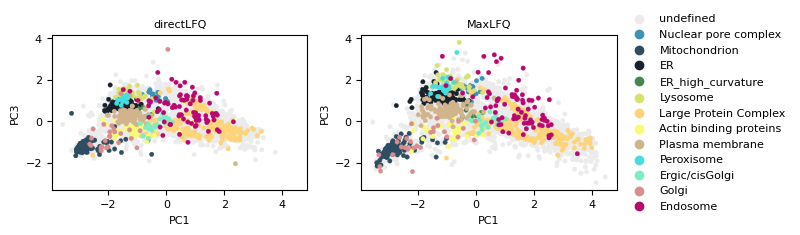

In [261]:
import seaborn as sns
display(df_global_pca)
fig, axes = plt.subplots(1,2, figsize=(8.3,2.3))
print(ordered_legends)
df_global_pca = df_global_pca.set_index("Compartment").loc[ordered_legends].reset_index()


df_directlfq = df_global_pca.loc[df_global_pca["Experiment"] == "directLFQ"]
df_maxlfq = df_global_pca.loc[df_global_pca["Experiment"] == "MaxLFQ"]


sns.scatterplot(data=df_directlfq, x="PC1", y="PC3", hue="Compartment", palette=colorlist_hex_final, ax=axes[0], legend=False, edgecolor = None, s = 10, hue_order=ordered_legends)
sns.scatterplot(data=df_maxlfq, x="PC1", y="PC3", hue="Compartment", palette=colorlist_hex_final, ax=axes[1], edgecolor = None, s = 10, hue_order=ordered_legends)
#add legend to the right
axes[0].set_title("directLFQ")
axes[1].set_title("MaxLFQ")
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, loc='center right', bbox_to_anchor=(1.7, 0.5), frameon= False)

#set same axis limits
axes[0].set_xlim(axes[1].get_xlim())
axes[0].set_ylim(axes[1].get_ylim())
fig.tight_layout()

#change zorder of a subset of the points
for ax in axes:
    for i, artist in enumerate(ax.get_children()):
        if isinstance(artist, matplotlib.collections.PathCollection) and i == 0:
            artist.set_zorder(1)


fig.savefig("pca_comparison.svg", bbox_inches='tight', dpi=300, transparent=True)
fig.savefig("pca_comparison.png", bbox_inches='tight', dpi=300, transparent=True)
fig.savefig("pca_comparison.pdf", bbox_inches='tight', dpi=300, transparent=True)
